# Trabalho 3
Descrição do trabalho:

http://webserver2.tecgraf.puc-rio.br/~mgattass/visao/trb/T3.html

Aluno: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import time
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

### Using the Numpy

#### Loss Functions

In [2]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

#### Activation Functions

In [3]:
def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1 - np.tanh(x) ** 2

In [4]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_prime(x):
  s = 1/(1+np.exp(-x))
  ds = s*(1-s)
  return ds

In [5]:
def relu(x):
  return np.maximum(0,x)

def relu_prime(x):
  return (x>0).astype(x.dtype)

#### class Layer

In [6]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

#### class Activation(Layer)

In [7]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

#### class Dense(Layer)

In [8]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(self.weights.T, output_gradient)
        # print( f'output_gradient.shape: {output_gradient.shape}' )
        d_weights = np.dot(output_gradient, self.input.T)
        d_bias = np.sum(output_gradient, axis=0).reshape((1, -1))

        # update parameters
        # print( f'learning_rate: {learning_rate}' )
        # print( f'd_weights.shape: {d_weights.shape}' )
        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias
        return input_gradient 

#### function predict()

In [9]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

#### function train()

In [10]:
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, batch_size = -1, verbose = True):

    if batch_size > 0: # train using batches

        n_samples = len(x_train)
        n_batches = n_samples//batch_size

        batches = list()
        batches_y = list()
        for k in range(n_batches):

              ini = k * batch_size
              end = (k + 1) * batch_size
              batch = x_train[ini:end]
              batch_y = y_train[ini:end]
              batches.append( batch )
              batches_y.append( batch_y )

        if (n_batches * batch_size < len(x_train)):

              batch = x_train[ n_batches * batch_size: ]
              batch_y = y_train[ n_batches * batch_size: ]
              batches.append( batch )
              batches_y.append( batch_y )

        # print( f'len(batches): {len(batches)}' )

        for e in range(epochs):

            error = 0
            for key, batch in enumerate(batches):

                print()

                batch_y = batches_y[key]
                batch_output = list()

                for key, item in enumerate(batch):

                    # forward
                    output = predict(network, item)
                    # print( f'output: {output}' )

                    batch_output.append( output )

                error += loss(batch_y, batch_output)
                print( f'error: {error}' )

                # backward
                grad = loss_prime(batch_y, batch_output) # b, n
                # grad = np.sum(grad, axis=0)
                print( f'grad.shape: {grad.shape}' )
                print( f'grad: {grad}' )
                # print( f'grad[0]: {grad[0]}' )
                # print( f'grad[1]: {grad[1]}' )
                for layer in reversed(network):
                    grad = layer.backward(grad, learning_rate)

            error /= len(batches)
            print( f'error /= len(batches): {error}' )

            if verbose:
                if e % 100 == 0:
                    print(f"{e}/{epochs}, error={error:.3}")

    else: # train item by item

        for e in range(epochs):
            error = 0
            for x, y in zip(x_train, y_train):
                # forward
                output = predict(network, x)

                # error
                error += loss(y, output)

                # backward
                grad = loss_prime(y, output)
                for layer in reversed(network):
                    grad = layer.backward(grad, learning_rate)

            error /= len(x_train)

            if verbose:
                if e % 100 == 0:
                    print(f"{e}/{epochs}, error={error:.3}")

#### Example: XOR

In [11]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

##### Neural Network

In [12]:
network = [
    Dense(input_size = 2, 
          output_size = 3),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 3, 
          output_size = 1),
    Activation(activation = tanh,
               activation_prime = tanh_prime),
]

##### Training

In [13]:
%%time

train(network, 
      loss = mse, 
      loss_prime = mse_prime, 
      x_train = X, 
      y_train = Y, 
      epochs = 10000, 
      learning_rate = 0.1)

0/10000, error=0.329
100/10000, error=0.212
200/10000, error=0.149
300/10000, error=0.0416
400/10000, error=0.00355
500/10000, error=0.0422
600/10000, error=0.00255
700/10000, error=0.00179
800/10000, error=0.00139
900/10000, error=0.00112
1000/10000, error=0.000934
1100/10000, error=0.0008
1200/10000, error=0.000699
1300/10000, error=0.00062
1400/10000, error=0.000556
1500/10000, error=0.000504
1600/10000, error=0.000461
1700/10000, error=0.000424
1800/10000, error=0.000392
1900/10000, error=0.000365
2000/10000, error=0.000341
2100/10000, error=0.00032
2200/10000, error=0.000301
2300/10000, error=0.000285
2400/10000, error=0.00027
2500/10000, error=0.000256
2600/10000, error=0.000244
2700/10000, error=0.000233
2800/10000, error=0.000222
2900/10000, error=0.000213
3000/10000, error=0.000204
3100/10000, error=0.000196
3200/10000, error=0.000189
3300/10000, error=0.000182
3400/10000, error=0.000176
3500/10000, error=0.00017
3600/10000, error=0.000164
3700/10000, error=0.000159
3800/10000

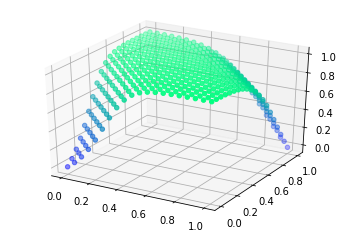

In [14]:
# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()

#### Example: MNIST

In [15]:
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

##### Loading the data

In [16]:
total_examples_train = 1000

In [17]:
total_examples_test = total_examples_train * .1
total_examples_test = int(total_examples_test)

In [18]:
x_train[0].shape

(28, 28)

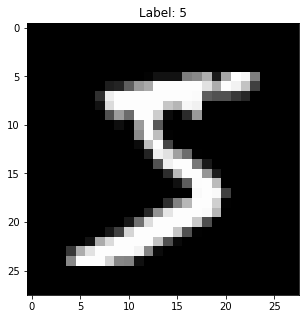

In [19]:
fig, axes = plt.subplots( 1, 1, figsize=( 10, 5 ) )

axes.set_title( f'Label: {y_train[0]}' )
axes.imshow( x_train[0], cmap='gray' )

plt.show()

In [20]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

##### Depicting examples

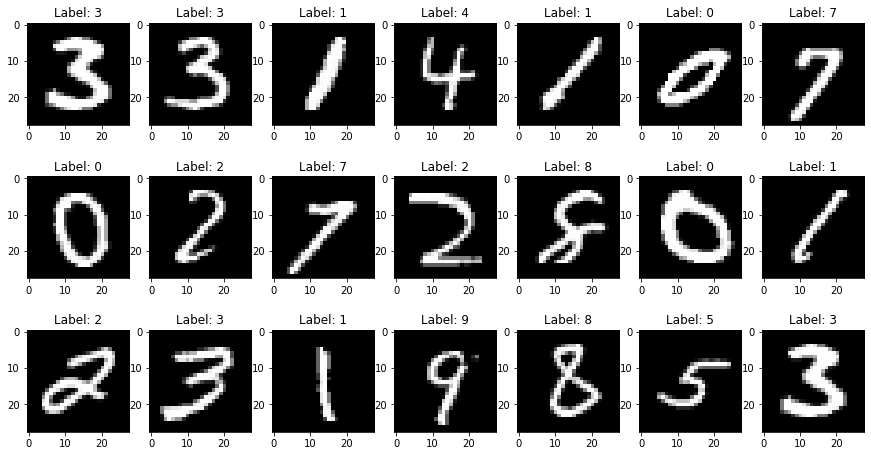

In [21]:
rows = 3
columns = 7

fig, axes = plt.subplots( rows, columns, figsize=( 15, 8 ) )

for i in range(rows):
  for j in range(columns):
    random_number = int(np.random.rand() * total_examples_train)
    axes[i][j].set_title( f'Label: {y_train[random_number]}' )
    axes[i][j].imshow( x_train[random_number], cmap='gray' )

plt.show()

##### Preprocessing Data

In [22]:
def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = np_utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]

In [23]:
x_train, y_train = preprocess_data(x_train, y_train, total_examples_train)
x_test, y_test = preprocess_data(x_test, y_test, total_examples_test)

##### Neural Network

In [24]:
network = [
    Dense(input_size = 28 * 28, 
          output_size = 40),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 40, 
          output_size = 10),
    Activation(activation = tanh,
               activation_prime = tanh_prime),
]

##### Training

In [25]:
%%time

train(network, 
      loss = mse, 
      loss_prime = mse_prime, 
      x_train = x_train, 
      y_train = y_train, 
      epochs = 100, 
      learning_rate = 0.1)
      # learning_rate = 0.1,
      # batch_size = 10)

0/100, error=0.897
CPU times: user 30.6 s, sys: 24.3 s, total: 55 s
Wall time: 28.3 s


##### Testing

In [26]:
print( f'len(y_test): {len(y_test)}' )

len(y_test): 100


In [27]:
%%time

y_predicted = list()
y_actual = list()

for x, y in zip(x_test, y_test):
    output = predict(network, x)

    y_predicted.append( np.argmax(output) )
    y_actual.append( np.argmax(y) )

    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

pred: 7 	true: 7
pred: 2 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 7 	true: 4
pred: 1 	true: 1
pred: 9 	true: 4
pred: 9 	true: 9
pred: 7 	true: 5
pred: 7 	true: 9
pred: 0 	true: 0
pred: 7 	true: 6
pred: 7 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 5 	true: 5
pred: 7 	true: 9
pred: 7 	true: 7
pred: 5 	true: 3
pred: 4 	true: 4
pred: 9 	true: 9
pred: 4 	true: 6
pred: 2 	true: 6
pred: 4 	true: 5
pred: 4 	true: 4
pred: 5 	true: 0
pred: 9 	true: 7
pred: 4 	true: 4
pred: 0 	true: 0
pred: 1 	true: 1
pred: 5 	true: 3
pred: 2 	true: 1
pred: 5 	true: 3
pred: 2 	true: 4
pred: 7 	true: 7
pred: 7 	true: 2
pred: 7 	true: 7
pred: 1 	true: 1
pred: 2 	true: 2
pred: 1 	true: 1
pred: 1 	true: 1
pred: 7 	true: 7
pred: 7 	true: 4
pred: 1 	true: 2
pred: 3 	true: 3
pred: 5 	true: 5
pred: 3 	true: 1
pred: 7 	true: 2
pred: 7 	true: 4
pred: 4 	true: 4
pred: 6 	true: 6
pred: 7 	true: 3
pred: 9 	true: 5
pred: 5 	true: 5
pred: 2 	true: 6
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 7 	true:

###### Confusion Matrix

In [28]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
# print(confusion_matrix)

In [29]:
# based on https://www.statology.org/confusion-matrix-python/

y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')

#create confusion matrix
print(pd.crosstab(y_actual, y_predicted))

Predicted  0   1  2  3  4  5  6   7  8  9
Actual                                   
0          7   0  0  0  0  1  0   0  0  0
1          0  11  1  1  0  0  0   0  0  1
2          0   1  4  1  0  0  0   2  0  0
3          0   0  0  5  0  4  0   2  0  0
4          0   0  1  0  6  0  0   5  0  2
5          0   0  0  1  1  3  0   1  0  1
6          0   0  2  0  1  0  4   3  0  0
7          0   0  0  0  0  0  0  13  0  2
8          0   0  0  0  0  0  0   1  1  0
9          0   0  0  0  0  0  0   7  0  4


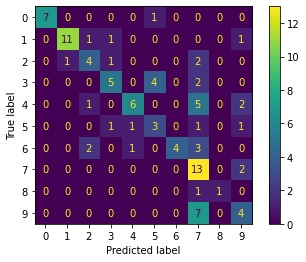

In [30]:
# based on https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, 
    display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

In [31]:
y_err = y_predicted[ y_predicted != y_actual ]
y_err[:20]

4     7
6     9
8     7
9     7
11    7
12    7
16    7
18    5
21    4
22    2
23    4
25    5
26    9
30    5
31    2
32    5
33    2
35    7
42    7
43    1
Name: Predicted, dtype: int64

#### Error Rate

"o valor da taxa de erro (calculada como o número de todas as previsões incorretas dividido pelo número total do conjunto de dados. A melhor taxa de erro é 0, enquanto a pior é 1.)"

In [32]:
error_rate = len(y_err) / total_examples_test
print( f'error_rate: {error_rate:.3}' )

error_rate: 0.42


In [33]:
error_rate_percentage = len(y_err) / total_examples_test * 100
print( f'error_rate_percentage: {error_rate_percentage:.3}%' )

error_rate_percentage: 42.0%
